This model is inspired by https://medium.com/mlreview/implementing-malstm-on-kaggles-quora-question-pairs-competition-8b31b0b16a07

In [137]:
import pandas as pd
from nltk.corpus import stopwords
from textblob import TextBlob
import re
import gensim
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import itertools
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K
from keras.layers import Input, Embedding, LSTM, merge, Lambda
from keras.models import Model
from keras.optimizers import Adadelta
from sklearn.metrics import confusion_matrix
from display_confusion_matrix import display_confusion_matrix

In [2]:
quora = pd.read_csv("train.csv")

In [27]:
quora.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


# Preprocessing

In [4]:
stop_words = stopwords.words('english')

In [5]:
def clean_question(q):
    """
    Clean the text in a given question to provide
    a list of relevent words
    """

    q = str(q)
    q = q.lower() # lowercase
    q = re.sub(r"what's", "what is ", q)
    q = re.sub(r"\'ve", " have ", q)
    q = re.sub(r"can't", "cannot ", q)
    q = re.sub(r"n't", " not ", q)
    q = re.sub(r"i'm", "i am ", q)
    q = re.sub(r"\'re", " are ", q)
    q = re.sub(r"\'d", " would ", q)
    q = re.sub(r"\'ll", " will ", q)
    q = re.sub(r"[^A-Za-z0-9]", " ", q)
    q = TextBlob(q).tokens #tokenize
    return q

In [6]:
# load google vectors
word2vec = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", 
                                             binary=True)

In [7]:
%%time
# cleans the the text in question1 and question2, and them turn them into integers
# while creating the dictionary
# Prepare embedding

# vocabulary store the index of each word
vocabulary = dict()
# used keep track of the index of different words
inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
questions_cols = ['question1', 'question2']
dataset = quora.copy()

# Iterate over the questions only of both training and test datasets
for index, row in dataset.iterrows():

    # Iterate through the text of both questions of the row
    for question in questions_cols:

        q2n = []  # q2n -> question numbers representation
        for word in clean_question(row[question]):

            # Check for unwanted words
            if word in stop_words and word not in word2vec.vocab:
                continue

            if word not in vocabulary:
                vocabulary[word] = len(inverse_vocabulary)
                q2n.append(len(inverse_vocabulary))
                inverse_vocabulary.append(word)
            else:
                q2n.append(vocabulary[word])

        # Replace questions as word to question as number representation
        dataset.set_value(index, question, q2n)

/home/ec2-user/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


CPU times: user 4min 10s, sys: 360 ms, total: 4min 10s
Wall time: 4min 10s


In [180]:
with open('vocabulary', 'wb') as f:
    pickle.dump(vocabulary, f)

In [8]:
dataset.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,"[1, 2, 3, 4, 5, 4, 6, 7, 8, 9, 10, 8, 11]","[1, 2, 3, 4, 5, 4, 6, 7, 8, 9, 10]",0
1,1,3,4,"[1, 2, 3, 12, 13, 14, 15, 16, 17]","[1, 18, 19, 20, 3, 21, 22, 23, 3, 13, 14, 15, ...",0
2,2,5,6,"[25, 26, 15, 27, 3, 28, 29, 30, 31, 32, 33, 34]","[25, 26, 30, 28, 35, 36, 5, 37, 38, 39]",0
3,3,7,8,"[40, 41, 15, 42, 43, 44, 25, 26, 15, 45, 46]","[47, 3, 48, 49, 50, 51, 52, 50, 2, 53, 5, 52, 51]",0
4,4,9,10,"[54, 55, 56, 8, 57, 58, 59, 60, 61, 62, 63, 64]","[54, 65, 18, 66, 8, 60, 57]",0


In [10]:
with open('quora_words_as_int', 'wb') as f:
    pickle.dump(dataset, f)

In [16]:
vocabulary['step'], inverse_vocabulary[:3]

(4, ['<unk>', 'what', 'is'])

# Create embedding matrix

In [22]:
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

In [23]:
embeddings.shape

(85367, 300)

In [24]:
# Build the embedding matrix by including google vectors for each word
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

# Training and validation sets

In [28]:
# find longest cleaned sentence
max_seq_length = max(dataset.question1.map(lambda x: len(x)).max(),
                     dataset.question2.map(lambda x: len(x)).max())
max_seq_length

217

In [181]:
with open('max_seq_length', 'wb') as f:
    pickle.dump(max_seq_length, f)

In [31]:
# 10% as validation set
X_train, X_val, y_train, y_val = train_test_split(dataset.drop('is_duplicate', axis=1)
                                                  , dataset.is_duplicate.copy(), 
                                                  test_size=0.1, random_state=8)

In [32]:
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

In [34]:
# question 1 and 2 seperately
X_train = {'left': X_train.question1, 'right': X_train.question2}
X_val = {'left': X_val.question1, 'right': X_val.question2}

In [36]:
# Convert labels to their numpy representations
y_train = y_train.values
y_val = y_val.values

# Zero padding

In [43]:
X_train['left'][0]

[1, 18, 96, 94, 20, 96, 974, 1583, 2667, 1146]

In [46]:
# padding make sure everything is of same size
for dataset, side in itertools.product([X_train, X_val], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

In [47]:
X_train['left'][0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

# Model

In [113]:
# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 5

In [114]:
# manhattn distance calculated for output of LSTM for question1 and question2
def exponent_neg_manhattan_distance(left, right):
    '''similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

In [115]:
# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

In [116]:
# embedding layer
embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], 
                            input_length=max_seq_length, trainable=False)
# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

In [117]:
# LSTM layer - single layer a this is a siamese network
shared_lstm = LSTM(n_hidden)
left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

In [118]:
# Calculates the distance as defined by the MaLSTM model
malstm_distance = Lambda(lambda x: exponent_neg_manhattan_distance(x[0], x[1]), 
                         lambda x: (x[0][0], 1))([left_output, right_output])
# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

In [119]:
# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)
malstm.compile(loss='binary_crossentropy', optimizer=optimizer, 
               metrics=['binary_crossentropy', 'accuracy'])
# model summary
malstm.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 217)          0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 217)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 217, 300)     25610100    input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 50)           70200       embedding_4[0][0]                
          

## Train model

In [120]:
malstm_trained = malstm.fit([X_train['left'], X_train['right']], 
                            y_train, batch_size=batch_size, epochs=n_epoch,
                            validation_data=([X_val['left'], 
                                              X_val['right']], y_val))

Train on 363861 samples, validate on 40429 samples
Epoch 1/5
363861/363861 [==============================] - 3655s 10ms/step - loss: 0.5168 - binary_crossentropy: 0.5168 - acc: 0.7540 - val_loss: 0.4789 - val_binary_crossentropy: 0.4789 - val_acc: 0.7803
Epoch 2/5
363861/363861 [==============================] - 3662s 10ms/step - loss: 0.4597 - binary_crossentropy: 0.4597 - acc: 0.7884 - val_loss: 0.4577 - val_binary_crossentropy: 0.4577 - val_acc: 0.7928
Epoch 3/5
363861/363861 [==============================] - 3674s 10ms/step - loss: 0.4420 - binary_crossentropy: 0.4420 - acc: 0.7986 - val_loss: 0.4474 - val_binary_crossentropy: 0.4474 - val_acc: 0.7971
Epoch 4/5
363861/363861 [==============================] - 3667s 10ms/step - loss: 0.4307 - binary_crossentropy: 0.4307 - acc: 0.8055 - val_loss: 0.4419 - val_binary_crossentropy: 0.4419 - val_acc: 0.8011
Epoch 5/5
363861/363861 [==============================] - 3665s 10ms/step - loss: 0.4225 - binary_crossentropy: 0.4225 - acc: 0.

In [121]:
malstm_trained.model.save("lstm_model")

# Evaluate predictions

In [127]:
pred_v = malstm_trained.model.predict([X_val['left'], X_val['right']], batch_size=batch_size)

In [135]:
pred_v = np.hstack(pred_v)

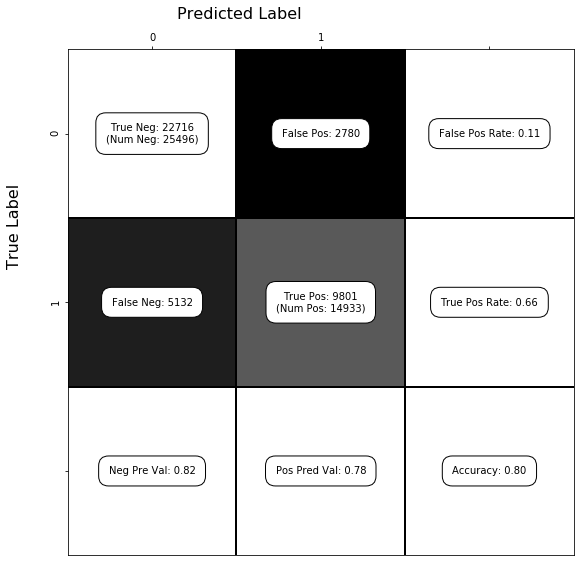

In [139]:
display_confusion_matrix(confusion_matrix(y_val, pred_v > 0.5))

In [164]:
# 10% as validation set
_, validation_set, _, _ = train_test_split(quora, quora.is_duplicate.copy(), 
                                           test_size=0.1, random_state=8)
validation_set.reset_index(drop=True, inplace=True)

In [175]:
# True positives
true_positives = (y_val == (pred_v > 0.5)) & (y_val==1)
for _, row in validation_set[true_positives][:5].iterrows():
    print((row['question1'], row['question2']))

('What is the best way to get free traffic to my website?', 'How can I get traffic for my website?')
('What is the most complex romantic situation you have ever faced?', 'What is the most complex romantic situation you ever faced?')
('How do you earn money from internet?', 'How does one earn money online without an investment from home?')
('Which is better: Uber or Ola? Why?', 'What is better Uber or Ola? Why?')
('How do you know if it is time for divorce?', 'How do you know if you should divorce?')


In [176]:
# True negatives
true_negatives = (y_val == (pred_v > 0.5)) & (y_val==0)
for _, row in validation_set[true_negatives][:5].iterrows():
    print((row['question1'], row['question2']))

('How can I integrate my Posterous blog into a Cargo Collective page?', 'How can I stop Posterous resizing my images?')
('Magic Tricks: What do I need to do to build a coat rack that I can pull out of a bag as Mary Poppins does. I was hoping to find a retractable one but no luck. What do magicians use when pulling out absurdly long objects from small containers?', 'What is the best magic show you have ever seen? Were you able to figure out the tricks?')
('How do I convince my girlfriend when her parents are scolding her badly?', 'How can I know that my girlfriend will really try to convince her parents?')
('What do you think about cultural appropriation? Is it really a thing?', "What's the big deal about cultural appropriation?")
('How do I become a real estate billionaire?', 'Can you become a real estate billionaire without making a company? If so, how?')


In [172]:
# Non dupilcated question pairs predicted as duplicated
false_positives = (y_val != (pred_v > 0.5)) & (y_val==0)
for _, row in validation_set[false_positives][:5].iterrows():
    print((row['question1'], row['question2']))

('How do I get freelance work?', 'How do I get my first freelancing work?')
('How do I increase my presence of mind?', 'How can one improve their presence of mind?')
('What are the best language exchange websites?', 'What is the best free website to find a language exchange?')
('What are the best free Microsoft Office alternatives?', "What's the best free alternative to Microsoft Office?")
('How do I  post a trending post on Quora?', 'How do I post in Quora?')


In [173]:
# Dupilcated question pairs predicted as non-duplicated
false_negatives = (y_val != (pred_v > 0.5)) & (y_val==1)
for _, row in validation_set[false_negatives][:5].iterrows():
    print((row['question1'], row['question2']))

('What makes a qualified doctor successful or failed?', 'What makes a successful doctor?')
('How do I choose the best taxi services in Udaipur?', 'How do I choose best taxi service in Udaipur? How can I find that?')
('What does an actuary do?', 'What do actuaries do?')
('What is the best question asked in your interview?', "What is the most interesting question you've been asked in an interview?")
('What are the most interesting fields ML is being used in today?', 'What are the most interesting applications of ML today?')
